## Corriente de electrones en sistemas abiertos de dos puntos cuánticos 

In [1]:
from joblib import delayed, Parallel

from tqdm.auto import tqdm
import numpy as np

import qutip as qt
import matplotlib.pyplot as plt
import scipy

%matplotlib widget

El Hamiltoniano del sistema en la base $\mathscr{B}=\{\ket{\varnothing}, \ket{L}, \ket{R}\}$:

$H= \begin{pmatrix}
        0 & 0 & 0 \\
        0 & \delta/2 & \tau/2 \\
        0 & \tau/2 & -\delta/2
    \end{pmatrix}$

In [2]:
# base
E = qt.basis(3, 0)
L = qt.basis(3, 1)
R = qt.basis(3, 2)

In [3]:
# parámetros y operadores
gammaL = 0.05
gammaR = 0.05
psi0 = E

cL = qt.Qobj(np.array([(0,1,0),(0,0,0),(0,0,0)]))
cR = qt.Qobj(np.array([(0,0,1),(0,0,0),(0,0,0)]))

LL = np.sqrt(gammaL)*cL
LR = np.sqrt(gammaR)*cR

c_ops = [qt.dag(LL),LR]

La corriente que se medirá vendrá dada por $I=e\rho_{RR}\Gamma_R$. Hacemos $\Gamma_R=\Gamma_L$.

In [4]:
def pixel(delta, tau):
    H = qt.Qobj(np.array([(0,0,0),(0,delta/2,tau/2), (0,tau/2,-delta/2)]))
    state = qt.steadystate(H, c_ops)
    pR = (R.overlap(state))
    return pR

In [5]:
# pintamos la corriente normalizada (I=rho_RR) para distintos valores del detuning y de tau
deltas = np.linspace(-6, 6, 201)
taus = np.linspace(0, 1, 200)

pRs = []
deltas_mat = []
taus_mat = []

for i in range(len(deltas)):
     for j in range(len(taus)):
        taus_mat.append(taus[j])
        deltas_mat.append(deltas[i])

In [6]:
pbar = tqdm(range(len(deltas_mat)), desc='Calculando...')
resultados = Parallel(n_jobs=-1)(delayed(pixel)(deltas_mat[i], taus_mat[i]) for i in pbar)
np.save('current_dqd.npy', resultados)

Calculando...:   0%|          | 0/40200 [00:00<?, ?it/s]

In [7]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

def hex_to_rgba(hex_color):
    """
    Convierte un color en formato hexadecimal a formato RGBA.
    
    Args:
    - hex_color: Color en formato hexadecimal.
    
    Returns:
    - Color en formato RGBA.
    """
    rgb = mcolors.hex2color(hex_color)
    return (*rgb, 1)

def create_custom_cmap(colors, positions):
    """
    Crea un colormap personalizado a partir de una lista de colores y sus posiciones.
    
    Args:
    - colors: Lista de colores en formato hexadecimal.
    - positions: Lista de posiciones normalizadas (entre 0 y 1).
    
    Returns:
    - Colormap personalizado.
    """
    if len(colors) != len(positions):
        raise ValueError("La longitud de 'colors' debe ser igual a la longitud de 'positions'.")
    
    rgba_colors = [hex_to_rgba(color) for color in colors]
    
    cmap_dict = {'red': [], 'green': [], 'blue': []}
    
    for pos, color in zip(positions, rgba_colors):
        for i, channel in enumerate(['red', 'green', 'blue']):
            cmap_dict[channel].append((pos, color[i], color[i]))
    
    return LinearSegmentedColormap('custom_colormap', cmap_dict)

# Definir lista de colores en formato hexadecimal y posiciones
hex_colors = ['w','#C1CFF6','#5F9EA0','#4D8283','#537E83','#DF9595','#E19B9B', '#F17F8A','#F13D70']
positions = [0.0, 0.05, 0.12,0.2,0.28,0.53,0.57,0.72,1]  # Normalizado entre 0 y 1

# Crear el colormap personalizado
custom_cmap = create_custom_cmap(hex_colors, positions)

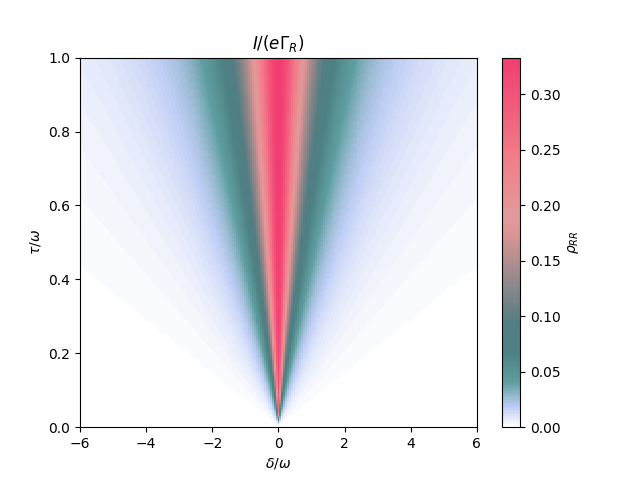

In [33]:
resultados_mat = np.array(resultados).reshape((len(deltas), len(taus)))

fig, ax = plt.subplots()
im = ax.imshow(resultados_mat.T, cmap = custom_cmap, origin='lower', aspect='auto',
                interpolation='none', extent=[min(deltas), max(deltas), min(taus), max(taus)])
plt.xlabel(r'$\delta/\omega$')
plt.ylabel(r'$\tau/\omega$')
plt.title(r'$I/(e\Gamma_R)$')
cbar = plt.colorbar(im)
cbar.ax.set_ylabel(r'$\rho_{RR}$')

plt.savefig('./figs/current_dqd.svg')

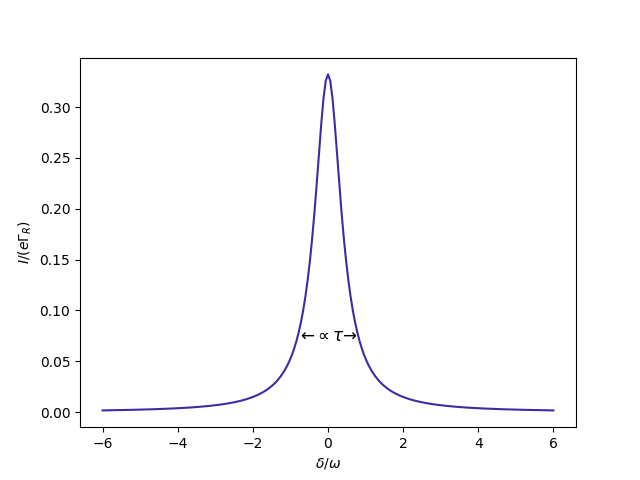

In [70]:
fig, ax = plt.subplots()
tau = 0.5
pRs=[]
for delta in deltas:
    H = qt.Qobj(np.array([(0,0,0),(0,delta/2,tau/2), (0,tau/2,-delta/2)]))
    state = qt.steadystate(H, c_ops)
    pRs.append((R.overlap(state)))

plt.plot(deltas, pRs, color = '#4229a6')

plt.xlabel(r'$\delta/\omega$')
plt.ylabel(r'$I/(e\Gamma_R)$')
plt.text(-0.75, 0.07, r'$←\propto \tau→$',fontsize = 12)

plt.savefig('./figs/current_dqd_plot.pdf')